# General

In [60]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from math import pi
import pandas as pd
import math
import tensorflow as tf
import pathlib
import os
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.set_printoptions(precision=3, suppress=True)
plt.style.use('dark_background')


In [5]:
import inspect
def print_t(t, full: bool = True, debug=False):
    if not debug:
        return
    # print(t)
    # return
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name,
             var_val in callers_local_vars if var_val is t]
    if len(names) == 0:
        names.append('')
    if full:
        if hasattr(t, "numpy"):
            print(f"{names[0]}{t.shape}", t.numpy(), sep='\n')
        elif type(t) is np.array:
            print(f"{names[0]}{t.shape}", t, sep='\n')
    else:
        print(f"{names[0]}{t.shape}")


In [6]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# Simplified

## Equations

\begin{aligned}
\partial_{t} c &= -\nabla \cdot (- \nabla c - c \nabla \Phi) ,\\
\nabla^2 \Phi &= -c .
\end{aligned}

\begin{aligned}
\partial_{x} c(t, 0) &= 0\\
\partial_{x} c(t, 1) &= 0\\
c(0, x) &= 1
\end{aligned}

\begin{aligned}
\Phi(0) &= 1\\
\Phi(1) &= 1\\
\end{aligned}

## Code

In [5]:
class GradientLayer(tf.keras.layers.Layer):
    def __init__(self, net, **kwargs):
        self.net = net
        self.p = kwargs
        super().__init__()
        # super().__init__(**kwargs)
        self.D = tf.constant(self.p["D"])
        self.xi = tf.constant(self.p["xi"])
        self.z = tf.constant(self.p["z"])
        self.e = tf.constant(self.p["e"])

    def call(self, x):
        p = self.p
        if "print_debug" in p:
            print_debug = p["print_debug"]
        else:
            print_debug = False
        sdim = p["sdim"]
        tdim = p["tdim"]

        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                r = self.net(x)
                c, Fi = r["c"], r["Fi"]

            print_t(c, debug=print_debug)
            c_jac = g.batch_jacobian(c, x)[..., 0, :]
            print_t(c_jac, debug=print_debug)
            c_t = c_jac[..., tdim]
            print_t(c_t, debug=print_debug)
            c_grd = c_jac[..., sdim]
            print_t(c_grd, debug=print_debug)

            print_t(Fi, debug=print_debug)
            Fi_jac = g.batch_jacobian(Fi, x)[..., 0, :]
            print_t(Fi_jac, debug=print_debug)
            Fi_grd = Fi_jac[..., sdim]
            print_t(Fi_grd, debug=print_debug)

            j = -p["D"]*c_grd - p["xi"]*p["z"]*p["e"]*c*Fi_grd
            print_t(j, debug=print_debug)

        Fi_grd_jac = gg.batch_jacobian(Fi_grd, x)
        print_t(Fi_grd_jac, debug=print_debug)
        Fi_lap = tf.linalg.trace(Fi_grd_jac[..., sdim])[:, None]
        print_t(Fi_lap, debug=print_debug)

        j_jac = gg.batch_jacobian(j, x)
        print_t(j_jac, debug=print_debug)
        j_div = tf.linalg.trace(j_jac[..., sdim])[:, None]
        print_t(j_div, debug=print_debug)

        return c, c_t, c_grd, \
               Fi_grd, Fi_lap, \
               j_div

In [44]:
class BoundaryGradientLayer(tf.keras.layers.Layer):
    def __init__(self, net, **kwargs):
        self.net = net
        self.p = kwargs
        super().__init__()

    def call(self, x):
        p = self.p
        sdim = p["sdim"]
        tdim = p["tdim"]
        with tf.GradientTape(persistent=True) as g:
            g.watch(x)
            r = self.net(x)
            c, Fi = r["c"], r["Fi"]
        c_jac = g.batch_jacobian(c, x)[..., 0, :]
        c_t = c_jac[..., tdim]
        c_grad = c_jac[..., sdim]
        return c, c_t, c_grad, Fi

In [7]:
def build_params(dim):
    p = {
        "D": 1.,
        "q": 1.,
        "l": 1,
        "kT": 1.,
        "nu": 1,
        "m": 1.,
        "c_right": 1, "c_start": 1,
        "Fi_left": 1, "Fi_right": 1,
        "dim": dim,
        "density_water": 1.,
        "z": 1.,
        "e": 1.,
        "ro": 1.,
        "print_debug": True,
    }
    trim = slice(0, 1+dim)
    p["p_grd"] = tf.constant([0.,1.,0.])[0:dim]
    if dim == 1:
        p["v_const"] = np.array([1.0])
    else :
        p["v_const"] = np.array([0., 1., 0.])[trim]
    p["min_dim"] = np.array([0., 0., 0., 0.])[trim]
    p["max_dim"] = np.array([1., 1., 1., 1.])[trim]
    p["step"] = np.array([1., 0.2,  0.2,  0.2])[trim]
    p["size"] = p["max_dim"] - p["min_dim"]
    p["tdim"] = slice(0, 1)
    p["sdim"] = slice(1, 1+dim)
    p["xi"] = p["D"]/p["kT"]
    return p


In [8]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)


In [45]:
def build_pinn(net, p):
    dim = p["dim"]
    ins = [
        tf.keras.layers.Input(shape=(1+dim,)),  # inside
        tf.keras.layers.Input(shape=(1+dim,)),  # left
        tf.keras.layers.Input(shape=(1+dim,)),  # right
        tf.keras.layers.Input(shape=(1+dim,)),  # start
    ]

    l, kT, z, p_grd, nu, ro, e = \
        p["l"],p["kT"],p["z"],p["p_grd"],p["nu"],p["ro"], p["e"]

    outs = []

    grads = GradientLayer(net, **p)
    c, c_t, c_grd, \
        Fi_grd, Fi_lap, j_div = \
        grads(ins[0])
    outs.append(c_t + j_div)
    outs.append(Fi_lap + 1*l*kT*(z*c))

    l_grad = BoundaryGradientLayer(net, **p)
    c_l, c_t_l, c_grad_l, Fi_l = l_grad(ins[1])
    outs.append(c_t_l)
    outs.append(Fi_l - p["Fi_left"])

    r_grad = BoundaryGradientLayer(net, **p)
    c_r, c_t_r, c_grad_r, Fi_r = r_grad(ins[2])
    outs.append(c_t_r)
    outs.append(Fi_r - p["Fi_right"])

    r_s = net(ins[3])
    c_s, Fi_s = r_s["c"], r_s["Fi"]
    outs.append(c_s - p["c_start"])

    return tf.keras.models.Model(inputs=ins, outputs=outs)

In [46]:
cases = [{}]
cases[0]["p"] = build_params(1)
cases[0]["net"] = build_net([80,40], 'tanh', **cases[0]["p"])
cases[0]["pinn"] = build_pinn(**cases[0])
cases[0]["pinn"].compile('adam', 'mse')

## Sandbox

In [ ]:
gl = BoundaryGradientLayer(cases[0]["net"], **cases[0]["p"])
x = tf.constant([[1, 2], [3, 4]], dtype=tf.float32)
gl(x)

## Tests

In [36]:
def train(pinn, p, **kwargs):
    n_train_samples = 10000
    n_train_epoch = 10
    
    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]

    x_train = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left[:, 1] = min_d[1]
    x_train_right = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_start[:, 0] = min_d[0]
    x = [x_train, x_train_left, x_train_right, x_train_start]

    y = [np.zeros((n_train_samples, 1))] * len(pinn.output)

    return pinn.fit(x=x, y=y, batch_size = 100, epochs = n_train_epoch, verbose=2)


In [ ]:
for i in range(40):
    train(**cases[0])

In [13]:
def test(net, p, num_test_samples = 1, **kwargs):
    dims = np.linspace(p["min_dim"], p["max_dim"], num_test_samples).T
    dims = np.split(dims.flatten(), p["dim"]+1)
    mdims = np.meshgrid(*dims, indexing='ij')
    txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)
    return dims, mdims, net.predict(txyz, batch_size=num_test_samples)

In [49]:
cases[0]["res"] = test(**cases[0], num_test_samples=101)

101/101 [==============================] - 0s 570us/step


4/4 [==============================] - 0s 1ms/step


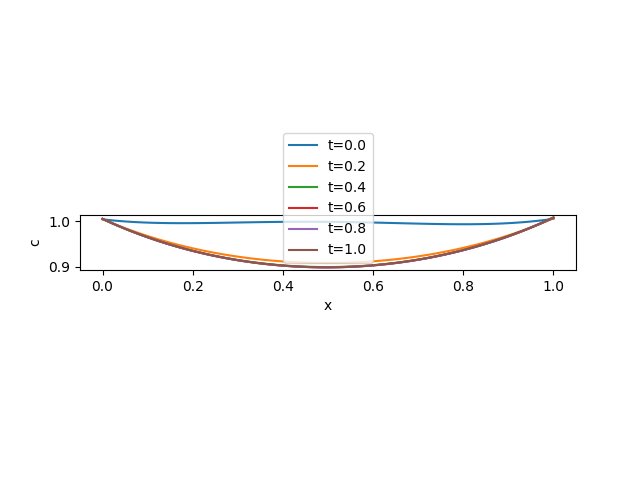

In [50]:
p = cases[0]["p"]
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel("x")
ax.set_ylabel("c")
for i in range(0, 6):
    t = np.full(100, i/5.)
    x = np.linspace(p["min_dim"][1], p["max_dim"][1], 100)
    dims = np.stack([t, x], axis=-1)
    res = cases[0]["net"].predict(dims)["c"]
    ax.plot(dims[:,1], res, label=f't={t[0]}')
    ax.set_aspect('equal', 'box')
    # ax.set_ylim(0, 1)
ax.legend()

In [28]:
def plot(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    ax = fig.add_subplot(121)

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    im = ax.pcolormesh(dims[0], dims[1], c)
    ax.set_ylim(0., 1.)
    ax.set_aspect('equal')
    fig.colorbar(im, label=d, fraction=0.046, pad=0.04)

    ax = fig.add_subplot(122)
    ax.set_xlabel("x")
    ax.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 5
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        ax.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    ax.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    ax.legend(loc='best')
    fig.tight_layout()


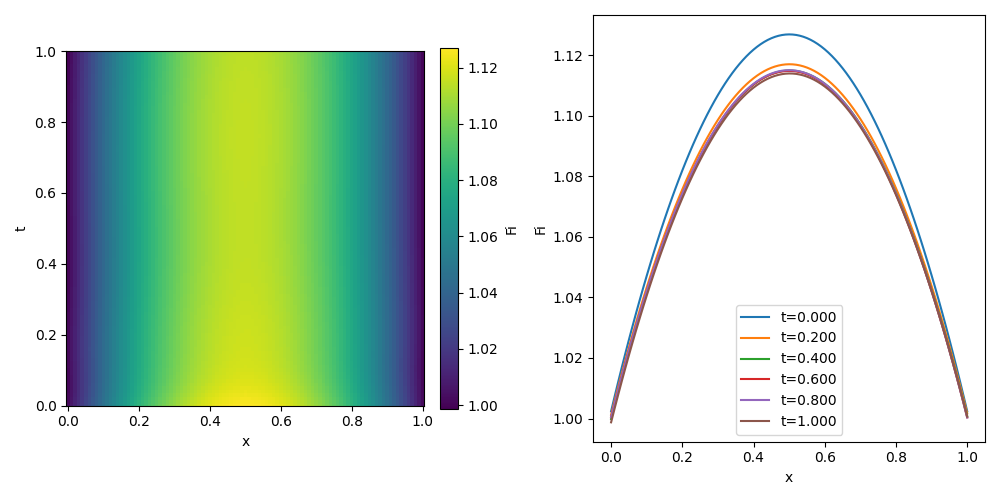

In [51]:
fig = plt.figure(figsize=(10,5))
plot(fig, "Fi", **cases[0])

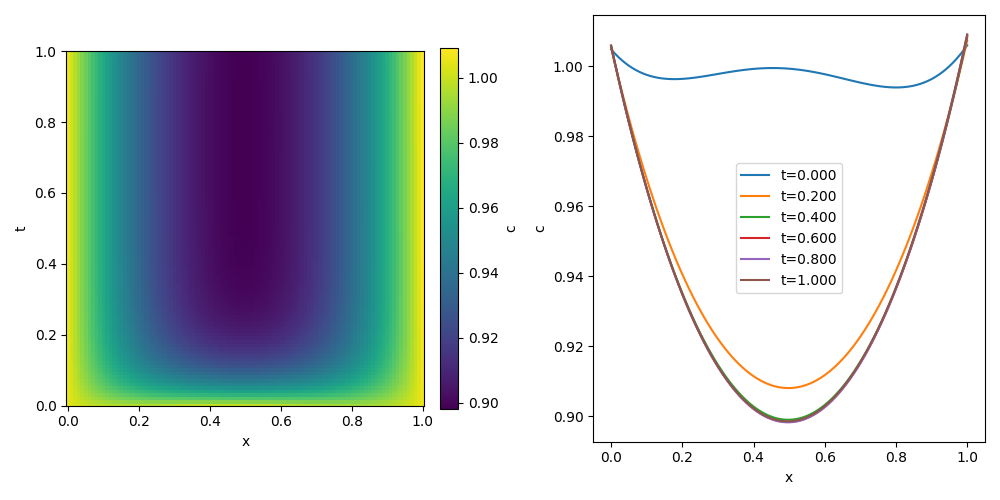

In [52]:
fig = plt.figure(figsize=(10,5))
plot(fig, "c", **cases[0])

# Original

## Equation

## Code

In [ ]:
class GradientLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        self.model = model
        self.p = kwargs
        super().__init__()
        # super().__init__(**kwargs)
        self.D = tf.constant(self.p["D"])
        self.xi = tf.constant(self.p["xi"])
        self.z = tf.constant(self.p["z"])
        self.e = tf.constant(self.p["e"])

    def call(self, x):
        p = self.p
        if "print_debug" in p:
            print_debug = p["print_debug"]
        else:
            print_debug = False
        sdim = p["sdim"]
        tdim = p["tdim"]

        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                r = self.model(x)
                c, v, Fi = r["c"], r["v"], r["Fi"]

            print_t(c, debug=print_debug)
            c_jac = g.batch_jacobian(c, x)[..., 0, :]
            print_t(c_jac, debug=print_debug)
            c_t = c_jac[..., tdim]
            print_t(c_t, debug=print_debug)
            c_grd = c_jac[..., sdim]
            print_t(c_grd, debug=print_debug)

            print_t(v, debug=print_debug)
            v_jac = g.batch_jacobian(v, x)
            print_t(v_jac, debug=print_debug)
            v_t = v_jac[..., tdim][..., 0]
            print_t(v_t, debug=print_debug)
            v_grd = v_jac[..., sdim]
            print_t(v_grd, debug=print_debug)
            v_div = tf.linalg.trace(v_grd)[:, None]
            print_t(v_div, debug=print_debug)
            v_adv = tf.reduce_sum(v[:, None]*v_grd, axis=-1)
            print_t(v_adv, debug=print_debug)

            print_t(Fi, debug=print_debug)
            Fi_jac = g.batch_jacobian(Fi, x)[..., 0, :]
            print_t(Fi_jac, debug=print_debug)
            Fi_grd = Fi_jac[..., sdim]
            print_t(Fi_grd, debug=print_debug)

            j = -p["D"]*c_grd - p["xi"]*p["z"]*p["e"]*c*Fi_grd + c*v
            print_t(j, debug=print_debug)

        v_grd2 = gg.batch_jacobian(v_grd, x)[..., sdim]
        print_t(v_grd2, debug=print_debug)
        v_lap = tf.linalg.trace(v_grd2)
        print_t(v_lap, debug=print_debug)

        Fi_grd_jac = gg.batch_jacobian(Fi_grd, x)
        print_t(Fi_grd_jac, debug=print_debug)
        Fi_lap = tf.linalg.trace(Fi_grd_jac[..., sdim])[:, None]
        print_t(Fi_lap, debug=print_debug)

        j_jac = gg.batch_jacobian(j, x)
        print_t(j_jac, debug=print_debug)
        j_div = tf.linalg.trace(j_jac[..., sdim])[:, None]
        print_t(j_div, debug=print_debug)

        return c, c_t, c_grd, \
               v_t, v_div, v_adv, v_lap, \
               Fi_grd, Fi_lap, \
               j_div


In [ ]:
def build_pinn(net, p):
    ins = []
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # inside
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # left
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # right
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # start
    ins.append(tf.keras.layers.Input(1))                    # Fi_start
    grads = GradientLayer(net, **p)

    outs = []

    l, kT, z, p_grd, nu, ro, e = \
        p["l"],p["kT"],p["z"],p["p_grd"],p["nu"],p["ro"], p["e"]

    c, c_t, c_grd, \
        v_t, v_div, v_adv, v_lap, \
        Fi_grd, Fi_lap, j_div = \
        grads(ins[0])
    outs.append(c_t + j_div)
    outs.append(Fi_lap + 4*pi*l*kT*(z*c))
    outs.append(ro*(v_t + v_adv) + p_grd - nu*v_lap + (kT*c_grd + z*e*c*Fi_grd))
    outs.append(v_div)

    r_l = net(ins[1])
    c_l, v_l, Fi_l = r_l["c"], r_l["v"], r_l["Fi"]
    outs.append(c_l - p["c_left"])
    outs.append(v_l - p["v_left"])
    outs.append(Fi_l - p["Fi_left"])

    r_r = net(ins[2])
    c_r, v_r, Fi_r = r_r["c"], r_r["v"], r_r["Fi"]
    outs.append(c_r - p["c_right"])
    outs.append(v_r - p["v_right"])
    outs.append(Fi_r - p["Fi_right"])

    r_s = net(ins[2])
    c_s, v_s, Fi_s = r_s["c"], r_s["v"], r_s["Fi"]
    outs.append(c_s - p["c_start"])
    outs.append(v_s - p["v_start"])
    outs.append(Fi_s - ins[4])

    return tf.keras.models.Model(inputs=ins, outputs=outs)

In [ ]:
# def build_params(dim):
#     p = {
#         "D": 0.006075,
#         "q": 1.,
#         "l": 0.7095,
#         "kT": 1.,
#         "nu": 79.53,
#         "m": 1.,
#         "c_left": 0.01, "c_right": 0.01, "c_start": 0.002,
#         "v_left": 0., "v_right": 0., "v_start": 0,
#         "Fi_left": -0.05, "Fi_right": -0.05, "Fi_start": np.array([[0,-0.05]]),
#         "width": 50.,
#         "dim": dim,
#         "density_water": 26.15,
#         "z": 1.,
#         "e": 1.,
#         "ro": 26.15,
#         "p_grd": tf.constant([0.,1.,0.]),
#     }
#     trim = slice(0, 1+p["dim"])
#     if dim == 1:
#         p["v_const"] = np.array([1.0])
#     else :
#         p["v_const"] = np.array([0., 1., 0.])[0:dim]
#     # p["Fi_start"] = np.loadtxt("Fi.dat")
#     p["p_grd"] = p["p_grd"][0:dim]
#     p["min_dim"] = np.array([ 0., -25., -3., -3.])[trim]
#     p["max_dim"] = np.array([10.,  25.,  3.,  3.])[trim]
#     p["step"] = np.array([1., 0.2,  0.2,  0.2])[trim]
#     p["size"] = p["max_dim"] - p["min_dim"]
#     p["tdim"] = slice(0, 1)
#     p["sdim"] = slice(1, 1+p["dim"])
#     p["xi"] = p["D"]/p["kT"]
#     return p


In [ ]:
def build_params(dim):
    p = {
        "D": 1,
        "q": 1.,
        "l": 1.,
        "kT": 1.,
        "nu": 1.,
        "m": 1.,
        "c_left": 1., "c_right": 1., "c_start": 0.2,
        "v_left": 0., "v_right": 0., "v_start": 0,
        "Fi_left": -1, "Fi_right": -1, "Fi_start": np.array([[0,-0.05]]),
        "width": 50.,
        "dim": dim,
        "density_water": 1.,
        "z": 1.,
        "e": 1.,
        "ro": 1.,
        "p_grd": tf.constant([0.,1.,0.]),
    }
    trim = slice(0, 1+p["dim"])
    if dim == 1:
        p["v_const"] = np.array([1.0])
    else :
        p["v_const"] = np.array([0., 1., 0.])[0:dim]
    # p["Fi_start"] = np.loadtxt("Fi.dat")
    p["p_grd"] = p["p_grd"][0:dim]
    p["min_dim"] = np.array([ 0., 0., 0., 0.])[trim]
    p["max_dim"] = np.array([ 1., 1., 1., 1.])[trim]
    p["step"] = np.array([0.05, 0.05, 0.05, 0.05])[trim]
    p["size"] = p["max_dim"] - p["min_dim"]
    p["tdim"] = slice(0, 1)
    p["sdim"] = slice(1, 1+p["dim"])
    p["xi"] = p["D"]/p["kT"]
    return p


In [ ]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "v": tf.keras.layers.Dense(dim, kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)


In [ ]:
cases = [{},{},{}]

act = 'tanh'
layers = [80, 40]
optimizer = 'adam'
loss = 'mse'
path = f"models/l={layers} act={act} opt={optimizer} loss={loss}"

In [ ]:
best_2dim = tf.keras.models.load_model("2dim model")

In [ ]:
for i in range(3):
    cases[i]["p"] = build_params(1+i)

In [ ]:
for i, case in enumerate(cases):
    cases[i]["net"] = build_net(layers=layers, activation=act, **case["p"])


In [ ]:
for i, case in enumerate(cases):
    cases[i]["pinn"] = build_pinn(case["net"], case["p"])
    cases[i]["pinn"].compile(optimizer=optimizer, loss=loss)

In [ ]:
for i, case in enumerate(cases):
    case["p"] = build_params(1+i)
    case["net"] = build_net(layers=layers, activation=act, **case["p"])
    case["pinn"] = build_pinn(**case)
    case["pinn"].compile(optimizer=optimizer, loss=loss)

In [ ]:
def train(pinn, p, **kwargs):
    n_train_samples = 10000
    n_train_epoch = 10
    
    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]

    x_train = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left[:, 1] = min_d[1]
    x_train_right = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_start[:, 0] = min_d[0]
    Fi_start = np.interp(x_train_start[:, 1], p["Fi_start"][:, 0], p["Fi_start"][:, 1])
    x = [x_train, x_train_left, x_train_right, x_train_start, Fi_start]

    y = [np.zeros((n_train_samples, 1))] * len(pinn.output)

    return pinn.fit(x=x, y=y, batch_size = 100, epochs = n_train_epoch, verbose=2)

for i in range(10):
    train(**cases[1])

In [ ]:
def train_grid(pinn, p, **kwargs):
    n_train_samples = 5
    n_train_epoch = 100

    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]

    dim_range = range(int(1+p["dim"]))

    coords = [np.arange(p["min_dim"][i], p["max_dim"][i], p["step"][i]) for i in dim_range]
    m_coords = np.meshgrid(*coords, indexing='ij')
    x_train = np.stack([m_coord.flatten() for m_coord in m_coords], axis=-1)
    
    x_train_left = np.copy(x_train)
    x_train_left[:, 1] = min_d[1]
    x_train_right = np.copy(x_train)
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.copy(x_train)
    x_train_start[:, 0] = min_d[0]
    Fi_start = np.interp(x_train_start[:, 1], p["Fi_start"][:, 0], p["Fi_start"][:, 1])
    x = [x_train, x_train_left, x_train_right, x_train_start, Fi_start]
    y = [np.zeros((x[0].shape[0], 1))] * len(pinn.output)

    return pinn.fit(x=x, y=y, batch_size = None, epochs = n_train_epoch)

h = train_grid(**cases[1])

In [ ]:
def test(net, p, num_test_samples = 30, **kwargs):
    dims = np.linspace(p["min_dim"], p["max_dim"], num_test_samples).T
    dims = np.split(dims.flatten(), p["dim"]+1)
    mdims = np.meshgrid(*dims, indexing='ij')
    txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)
    return dims, mdims, net.predict(txyz, batch_size=num_test_samples)

cases[1]["res"] = test(**cases[1])

In [ ]:
def plot(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot(121)

    axc.set_xlabel("x")
    axc.set_ylabel("t")
    im = axc.pcolormesh(dims[0], dims[1], c)
    axc.set_ylim(0., 1.)
    fig.colorbar(im, label=d)

    axc = fig.add_subplot(122)
    axc.set_xlabel("x")
    axc.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 10
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        axc.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    axc.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    axc.legend(loc='best')
    fig.tight_layout()


In [ ]:
fig = plt.figure(figsize=(10,4))
plot(fig, "Fi", **cases[0])

In [ ]:
fig = plt.figure(figsize=(10,4))
plot(fig, "c", **cases[0])

In [ ]:
def plot2d(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot(121)

    axc.set_xlabel("x")
    axc.set_ylabel("y")
    im = axc.pcolormesh(dims[1], dims[2], c[0].T)
    fig.colorbar(im).ax.set_ylabel(d, labelpad=0)

    axc = fig.add_subplot(122)
    axc.set_xlabel("x")
    axc.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 5
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        axc.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    axc.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    axc.legend(loc='best')
    fig.tight_layout()

In [ ]:
Fi = np.reshape(cases[1]["res"][2]["Fi"], cases[1]["res"][1][1].shape)
Fi[-1, 0, 15]

In [ ]:
fig = plt.figure(figsize=(10,4))
plot2d(fig, "Fi", **cases[1])

In [ ]:
fig = plt.figure(figsize=(10,4))
plot2d(fig, "c", **cases[1])

In [ ]:
def plot_c(fig: plt.Figure, i, res, p, **kwargs):
    dims, mdims, data = res
    c = data["c"]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot()

    analit = np.loadtxt("eof_analytical.dat")
    axc.plot(analit[:, 0], analit[:, 1], 'o', mfc="none", label='analit')
    axc.set_title(f'Размерность: {p["dim"]}')
    axc.set_xlabel("x")
    axc.set_ylabel("c")

    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    for t in range(0, 30, 5):
        axc.plot(dims[1], c[(t, slice(None),) + other_dim], label=f't={dims[0][t]:.3f}')
    last_idx = dims[1].shape[0] - 1
    axc.plot(dims[1], c[(last_idx, slice(None),) + other_dim], label=f't={dims[0][last_idx]:.3f}')
    axc.legend(loc='best')
    # axc.set_ylim(top=0.01)


In [ ]:
cases[2]["net"].save("3dim model relu 30000000")

In [ ]:
fig = plt.figure()
res = test(best_2dim, cases[2]["p"])
plot_c(fig, 2, res, cases[2]["p"])

In [ ]:
fig = plt.figure()
plot_c(fig, 2, **cases[2])

In [ ]:
fig = plt.figure()
plot_c(fig, 2, **cases[2])

In [ ]:
fig = plt.figure()
plot_c(fig, 2, **cases[2])

In [ ]:
def plot_c_y(fig: plt.Figure, i, res, p, **kwargs):
    dims, mdims, data = res
    c = data["c"]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot()

    analit = np.loadtxt("eof_analytical.dat")
    axc.plot(analit[:, 0], analit[:, 1], 'o', mfc="none", label='analit')
    axc.set_title(f'Размерность: {p["dim"]}')
    axc.set_xlabel("x")
    axc.set_ylabel("c")

    other_dim = tuple(int(s) for s in p["size"][1:] / 2)
    for t in range(0, 50, 10):
        axc.plot(dims[1], c[t,other_dim[0], :], label=f't={t}')
    last_idx = dims[1].shape[0] - 1
    axc.plot(dims[1], c[t, other_dim[0], :], label=f't={last_idx}')
    axc.legend(loc='best')
    # axc.set_ylim(top=0.01)

fig = plt.figure()
plot_c_y(fig, 2, **cases[1])

In [ ]:
def save(net):
    p = path + f"/{net.layers[0].output_shape[-1][-1]-1}"
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)
    net.save(p)

In [ ]:
networks = [
    tf.keras.models.load_model(path+'/1'),
    tf.keras.models.load_model(path+'/2'),
    tf.keras.models.load_model(path+'/3'),
]

In [ ]:
def build_net(layers, activation, **kwargs):

    # input layer
    inputs = tf.keras.layers.Input(shape=(1+kwargs["dim"],))
    # hidden layers
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "v": tf.keras.layers.Dense(kwargs["dim"], kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)


# Random Samplling

In [209]:
def build_params(dim):
    p = {
        "D": 0.006075,
        "q": 1.,
        "l": 0.7095,
        "kT": 1.,
        "nu": 79.53,
        "m": 1.,
        "c_left": 0.01, "c_right": 0.01, "c_start": 0.002,
        "v_left": 0., "v_right": 0., "v_start": 0,
        "Fi_left": -0.05, "Fi_right": -0.05, "Fi_start": np.array([[0,-0.05]]),
        "width": 50.,
        "dim": dim,
        "density_water": 26.15,
        "z": 1.,
        "e": 1.,
        "ro": 26.15,
        "p_grd": tf.constant([0.,1.,0.]),
    }
    trim = slice(0, 1+p["dim"])
    if dim == 1:
        p["v_const"] = np.array([1.0])
    else :
        p["v_const"] = np.array([0., 1., 0.])[0:dim]
    # p["Fi_start"] = np.loadtxt("Fi.dat")
    p["p_grd"] = p["p_grd"][0:dim]
    p["min_dim"] = np.array([ 0., -25., -3., -3.])[trim]
    p["max_dim"] = np.array([36000.,  25.,  3.,  3.])[trim]
    p["step"] = np.array([1., 0.2,  0.2,  0.2])[trim]
    p["size"] = p["max_dim"] - p["min_dim"]
    p["tdim"] = slice(0, 1)
    p["sdim"] = slice(1, 1+p["dim"])
    p["xi"] = p["D"]/p["kT"]
    return p


In [215]:
class GradientLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        self.model = model
        self.p = kwargs
        super().__init__(name=kwargs["name"])
        # super().__init__(**kwargs)
        self.D = tf.constant(self.p["D"])
        self.xi = tf.constant(self.p["xi"])
        self.z = tf.constant(self.p["z"])
        self.e = tf.constant(self.p["e"])

    def call(self, x):
        p = self.p
        if "print_debug" in p:
            print_debug = p["print_debug"]
        else:
            print_debug = False
        sdim = p["sdim"]
        tdim = p["tdim"]

        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                r = self.model(x)
                c, v, Fi = r["c"], r["v"], r["Fi"]

            print_t(c, debug=print_debug)
            c_jac = g.batch_jacobian(c, x)[..., 0, :]
            print_t(c_jac, debug=print_debug)
            c_t = c_jac[..., tdim]
            print_t(c_t, debug=print_debug)
            c_grd = c_jac[..., sdim]
            print_t(c_grd, debug=print_debug)

            print_t(v, debug=print_debug)
            v_jac = g.batch_jacobian(v, x)
            print_t(v_jac, debug=print_debug)
            v_t = v_jac[..., tdim][..., 0]
            print_t(v_t, debug=print_debug)
            v_grd = v_jac[..., sdim]
            print_t(v_grd, debug=print_debug)
            v_div = tf.linalg.trace(v_grd)[:, None]
            print_t(v_div, debug=print_debug)
            v_adv = tf.reduce_sum(v[:, None]*v_grd, axis=-1)
            print_t(v_adv, debug=print_debug)

            print_t(Fi, debug=print_debug)
            Fi_jac = g.batch_jacobian(Fi, x)[..., 0, :]
            print_t(Fi_jac, debug=print_debug)
            Fi_grd = Fi_jac[..., sdim]
            print_t(Fi_grd, debug=print_debug)

            j = -p["D"]*c_grd - p["xi"]*p["z"]*p["e"]*c*Fi_grd + c*v
            print_t(j, debug=print_debug)

        v_grd2 = gg.batch_jacobian(v_grd, x)[..., sdim]
        print_t(v_grd2, debug=print_debug)
        v_lap = tf.linalg.trace(v_grd2)
        print_t(v_lap, debug=print_debug)

        Fi_grd_jac = gg.batch_jacobian(Fi_grd, x)
        print_t(Fi_grd_jac, debug=print_debug)
        Fi_lap = tf.linalg.trace(Fi_grd_jac[..., sdim])[:, None]
        print_t(Fi_lap, debug=print_debug)

        j_jac = gg.batch_jacobian(j, x)
        print_t(j_jac, debug=print_debug)
        j_div = tf.linalg.trace(j_jac[..., sdim])[:, None]
        print_t(j_div, debug=print_debug)

        return c, c_t, c_grd, \
               v, v_t, v_div, v_adv, v_lap, \
               Fi, Fi_grd, Fi_lap, \
               j_div


In [211]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "v": tf.keras.layers.Dense(dim, kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)

In [212]:
def build_pinn(net, p):
    # ins = []
    # ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # 0 position
    # ins.append(tf.keras.layers.Input(shape=(1,)))           # 1 density
    # ins.append(tf.keras.layers.Input(shape=(p["dim"],)))    # 2 velocity
    # ins.append(tf.keras.layers.Input(shape=(1,)))           # 3 potential
    # ins = {
    #     "pos": tf.keras.layers.Input(shape=(1+p["dim"],)),
    #     "c": tf.keras.layers.Input(shape=(1,)),
    #     "v": tf.keras.layers.Input(shape=(p["dim"],)),
    #     "Phi": tf.keras.layers.Input(shape=(1,))
    # }
    ins = tf.keras.layers.Input(shape=(1+p["dim"],))
    grads = GradientLayer(net, **p, name="gl")

    l, kT, z, p_grd, nu, ro, e = \
        p["l"], p["kT"], p["z"], p["p_grd"], p["nu"], p["ro"], p["e"]

    c, c_t, c_grd, \
        v, v_t, v_div, v_adv, v_lap, \
        Fi, Fi_grd, Fi_lap, j_div = \
        grads(ins)

    # outs = []
    # outs.append(c_t + j_div)
    # outs.append(Fi_lap + (4*l*kT)*c)
    # outs.append(ro*(v_t + v_adv) + p_grd - nu * v_lap + (kT*c_grd + z*e*c*Fi_grd))
    # outs.append(v_div)

    # outs.append(c)
    # outs.append(v)
    # outs.append(Fi)

    outs = {
        "eq1": c_t + j_div,
        "eq2": Fi_lap + (4*l*kT)*c,
        "eq3": ro*(v_t + v_adv) + p_grd - nu * v_lap + (kT*c_grd + z*e*c*Fi_grd),
        "eq4": v_div,
        "c": c,
        "v": v,
        "Fi": Fi, 
        }

    pinn = tf.keras.models.Model(inputs=ins, outputs=outs)
    pinn.compile('adam', 'mse')
    return pinn


In [235]:
def train(pinn):
    n_train_part = 0.5
    epoch = 10
    iter = 1
    pos = np.load("ek_sim_data/position.npy")
    pos = pos.reshape(-1, pos.shape[-1])
    data_count = pos.shape[0]
    c = np.load("ek_sim_data/density.npy").reshape(data_count, -1)
    Fi = np.load("ek_sim_data/potential.npy").reshape(data_count, -1)
    v = np.load("ek_sim_data/velocity.npy").reshape(data_count, -1)
    for i in range(iter):
        count = int(pos.shape[0]*n_train_part)
        idx = np.random.choice(pos.shape[0], count, replace=False)
        # pinn.fit(
        #     x=pos[idx],
        #     y=[np.zeros(count),
        #        np.zeros(count),
        #        np.zeros(count),
        #        np.zeros(count),
        #        c[idx],
        #        v[idx],
        #        Fi[idx],
        #       ], epochs=epoch)
        pinn.fit(
            x=pos[idx],
            y={"eq1": np.zeros(count),
               "eq2": np.zeros(count),
               "eq3": np.zeros(count),
               "eq4": np.zeros(count),
               "c": c[idx],
               "v": v[idx],
               "Fi": Fi[idx],
              }, epochs=epoch)



In [233]:
p = build_params(3)
net = build_net([80, 40], 'tanh', **p)
pinn = build_pinn(net, p)

2250/2250 [==============================] - 8s 2ms/step - loss: 22.4516 - gl_loss: 1.0077 - gl_1_loss: 0.0042 - tf.__operators__.add_176_loss: 0.0045 - tf.__operators__.add_177_loss: 0.0558 - tf.__operators__.add_181_loss: 21.2879 - gl_2_loss: 9.6975e-04 - gl_3_loss: 0.0904


In [236]:
train(pinn)

Epoch 1/10
2250/2250 [==============================] - 4s 2ms/step - loss: 2.6099 - gl_loss: 1.0008 - gl_1_loss: 4.0353e-04 - tf.__operators__.add_176_loss: 0.0013 - tf.__operators__.add_177_loss: 0.0045 - tf.__operators__.add_181_loss: 1.5987 - gl_2_loss: 8.0926e-05 - gl_3_loss: 0.0041
Epoch 2/10
2250/2250 [==============================] - 4s 2ms/step - loss: 1.7304 - gl_loss: 1.0005 - gl_1_loss: 2.6933e-04 - tf.__operators__.add_176_loss: 6.5726e-04 - tf.__operators__.add_177_loss: 0.0026 - tf.__operators__.add_181_loss: 0.7243 - gl_2_loss: 5.5308e-05 - gl_3_loss: 0.0022
Epoch 3/10
2250/2250 [==============================] - 4s 2ms/step - loss: 1.4885 - gl_loss: 0.9976 - gl_1_loss: 1.6487e-04 - tf.__operators__.add_176_loss: 3.2929e-04 - tf.__operators__.add_177_loss: 0.0016 - tf.__operators__.add_181_loss: 0.4875 - gl_2_loss: 2.6618e-05 - gl_3_loss: 0.0013
Epoch 4/10
2250/2250 [==============================] - 4s 2ms/step - loss: 1.3530 - gl_loss: 0.9894 - gl_1_loss: 1.1511e-04 

In [217]:
def test(net, p, num_test_samples = 30, **kwargs):
    dims = np.linspace(p["min_dim"], p["max_dim"], num_test_samples).T
    dims = np.split(dims.flatten(), p["dim"]+1)
    mdims = np.meshgrid(*dims, indexing='ij')
    txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)
    return dims, mdims, net.predict(txyz, batch_size=num_test_samples)

In [237]:
res = test(net, p)

27000/27000 [==============================] - 15s 570us/step


In [238]:
def plot(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot(121)

    axc.set_xlabel("x")
    axc.set_ylabel("t")
    im = axc.pcolormesh(dims[0], dims[1], c[..., 0, 0])
    axc.set_ylim(0., 1.)
    fig.colorbar(im, label=d)

    axc = fig.add_subplot(122)
    axc.set_xlabel("x")
    axc.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 5
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        axc.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    axc.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    axc.legend(loc='best')
    fig.tight_layout()

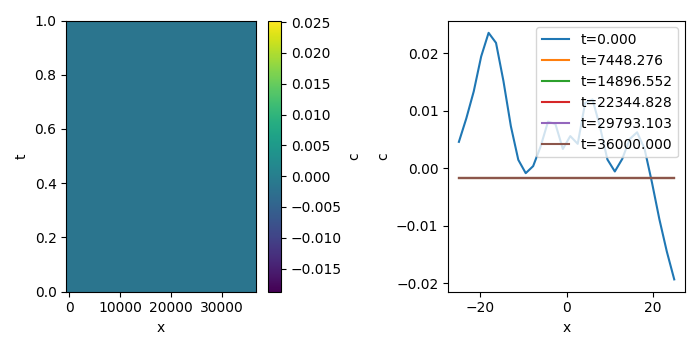

In [239]:
fig = plt.figure()
plot(fig, "c", res, p)

# Thermal

In [73]:
def inner_cond(f):
    return tf.cos(f) + tf.sin(f) + tf.sin(2*f) + 5*tf.sin(3*f) + 1

def outer_cond(f):
    return tf.sin(2*f) + tf.sin(3*f) + tf.cos(4*f)

In [278]:
from matplotlib import cm

inputs = tf.keras.layers.Input(shape=(2,))  # r, f
x = inputs
for layer in [16, 8]:
    x = tf.keras.layers.Dense(layer, activation='tanh',
                                kernel_initializer='he_normal')(x)
out = tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)
net = tf.keras.models.Model(inputs=inputs, outputs=out)

inputs = [
    tf.keras.layers.Input(shape=2),
    tf.keras.layers.Input(shape=2),
    tf.keras.layers.Input(shape=2),
]

class GL(tf.keras.layers.Layer):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def call(self, x):
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                res = net(x)
            u_grad = g.batch_jacobian(res, x)[...,0,:]
            u_r = u_grad[...,0]
            u_f = u_grad[...,1]
        u_jac2 = gg.batch_jacobian(u_grad, x)
        u_r2 = u_jac2[..., 0, 0]
        u_f2 = u_jac2[..., 1, 1]
        return u_r2 + 1/x[..., 0]*u_r + 1/x[..., 0]**2*u_f2
gl = GL(net)
lap = gl(inputs[0])

u_inner = net(inputs[1])
inner = u_inner

u_outer = net(inputs[2])
outer = u_outer

pinn = tf.keras.Model(inputs=inputs, outputs=[lap, inner, outer])
pinn.compile('adam', 'mse')


In [279]:
train_inner = []
train_outer = []

for i in range(1):
    train_n = 100000

    rf = np.random.rand(train_n, 2)
    rf[..., 0] = rf[..., 0] + 1
    rf[..., 1] = rf[..., 1] * 2*np.pi

    rf_inner = np.random.rand(train_n, 2)
    rf_inner[..., 0] = 1
    rf_inner[..., 1] = rf_inner[..., 1] * 2*np.pi
    # train_inner.append([rf_inner[..., 1], inner_cond(rf_inner[..., 1])])

    rf_outer = np.random.rand(train_n, 2)
    rf_outer[..., 0] = 2
    rf_outer[..., 1] = rf_outer[..., 1] * 2*np.pi
    # train_outer.append([rf_outer[..., 1], outer_cond(rf_outer[..., 1])])

    x_train = [rf, rf_inner, rf_outer]
    y_train = [
        np.zeros((train_n, 1)),
        inner_cond(rf_inner[..., 1]),
        outer_cond(rf_outer[..., 1]),
        ]
    pinn.fit(x_train, y_train, epochs = 100)

Epoch 1/100
3125/3125 [==============================] - 4s 811us/step - loss: 11.7488 - gl_24_loss: 0.2084 - model_95_loss: 10.2358 - model_95_1_loss: 1.3046
Epoch 2/100
3125/3125 [==============================] - 3s 805us/step - loss: 10.5519 - gl_24_loss: 0.2232 - model_95_loss: 9.2383 - model_95_1_loss: 1.0904
Epoch 3/100
3125/3125 [==============================] - 3s 800us/step - loss: 10.0730 - gl_24_loss: 0.2438 - model_95_loss: 8.8037 - model_95_1_loss: 1.0255
Epoch 4/100
3125/3125 [==============================] - 3s 810us/step - loss: 9.6655 - gl_24_loss: 0.2709 - model_95_loss: 8.4138 - model_95_1_loss: 0.9807
Epoch 5/100
3125/3125 [==============================] - 2s 791us/step - loss: 9.2384 - gl_24_loss: 0.2590 - model_95_loss: 8.0738 - model_95_1_loss: 0.9056
Epoch 6/100
3125/3125 [==============================] - 2s 787us/step - loss: 8.8501 - gl_24_loss: 0.2856 - model_95_loss: 7.7279 - model_95_1_loss: 0.8365
Epoch 7/100
3125/3125 [==============================]

KeyboardInterrupt: 

In [ ]:
r = np.linspace(1., 2., 50)
f = np.linspace(0, 2*np.pi, 50)
R, F = np.meshgrid(r, f)
Z = net.predict(np.stack([R.flatten(),F.flatten()], axis=-1)).reshape(R.shape)
X, Y = R*np.cos(F), R*np.sin(F)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm)

In [ ]:
n_test = 200
f = np.linspace(0, 2*np.pi, n_test)
analit_in = inner_cond(f)
analit_out = outer_cond(f)
pred_in = net.predict(np.stack([np.full((n_test,), 1.), f], axis=-1))
pred_out = net.predict(np.stack([np.full((n_test,), 2.), f], axis=-1))

fig = plt.figure(figsize=(15.,5.))
ax1 = fig.add_subplot(121)
ax1.plot(f, analit_in, 'o', mfc="none", label='analit')
ax1.plot(f, pred_in, label='predict')
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(f, analit_out, 'o', mfc="none", label='analit')
ax2.plot(f, pred_out, label='predict')
ax2.legend()

# Thermal Random Sampling

In [4]:
def solution(r, f):
    sin = tf.sin
    cos = tf.cos
    ln = tf.math.log
    return 1 - ln(r) / ln(tf.constant(2., dtype=tf.float64)) + \
        (-r/3 + 4/(3*r))*(sin(f) + cos(f)) + \
        (r**2/5 + 4/(5*r**2))*sin(2*f) + \
        (3*r**3/63 + 312/(64*r**3))*sin(3*f) + \
        (16*r**4/255 - 16/(255*r**4))*cos(4*f)


In [9]:
inputs = tf.keras.layers.Input(shape=(2,))  # r, f
x = inputs
for layer in [16, 8]:
    x = tf.keras.layers.Dense(layer, activation='tanh',
                                kernel_initializer='he_normal')(x)
out = tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)
net = tf.keras.models.Model(inputs=inputs, outputs=out)

inputs = tf.keras.layers.Input(shape=2)
class GL(tf.keras.layers.Layer):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def call(self, x):
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                u = net(x)
            u_grad = g.batch_jacobian(u, x)[...,0,:]
            u_r = u_grad[...,0]
            u_f = u_grad[...,1]
        u_jac2 = gg.batch_jacobian(u_grad, x)
        u_r2 = u_jac2[..., 0, 0]
        u_f2 = u_jac2[..., 1, 1]
        return u, u_r2 + 1/x[..., 0]*u_r + 1/x[..., 0]**2*u_f2

pinn = tf.keras.Model(inputs=inputs, outputs=GL(net)(inputs))
pinn.compile('adam', 'mse')


In [ ]:
for i in range(1):
    train_n = 100000

    rf = np.random.rand(train_n, 2)
    rf[..., 0] = rf[..., 0] + 1
    rf[..., 1] = rf[..., 1] * 2*np.pi

    x_train = rf
    y_train = [
        solution(rf[..., 0], rf[..., 1]),
        np.zeros((train_n, 1)),
        ]
    h = pinn.fit(x_train, y_train, epochs = 100)

In [45]:
def foo(layers):
    inputs = tf.keras.layers.Input(shape=(2,))  # r, f
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation='tanh',
                                    kernel_initializer='he_normal')(x)
    out = tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)
    net = tf.keras.models.Model(inputs=inputs, outputs=out)

    inputs = tf.keras.layers.Input(shape=2)
    class GL(tf.keras.layers.Layer):
        def __init__(self, net):
            super().__init__()
            self.net = net

        def call(self, x):
            with tf.GradientTape(persistent=True) as gg:
                gg.watch(x)
                with tf.GradientTape(persistent=True) as g:
                    g.watch(x)
                    u = net(x)
                u_grad = g.batch_jacobian(u, x)[...,0,:]
                u_r = u_grad[...,0]
                u_f = u_grad[...,1]
            u_jac2 = gg.batch_jacobian(u_grad, x)
            u_r2 = u_jac2[..., 0, 0]
            u_f2 = u_jac2[..., 1, 1]
            return u, u_r2 + 1/x[..., 0]*u_r + 1/x[..., 0]**2*u_f2

    pinn = tf.keras.Model(inputs=inputs, outputs=GL(net)(inputs))
    pinn.compile('adam', 'mse')

    train_n = 100000

    rf = np.random.rand(train_n, 2)
    rf[..., 0] = rf[..., 0] + 1
    rf[..., 1] = rf[..., 1] * 2*np.pi

    x_train = rf
    y_train = [
        solution(rf[..., 0], rf[..., 1]),
        np.zeros((train_n, 1)),
        ]
    time_log = TimeHistory()
    h = pinn.fit(x_train, y_train, epochs = 100, callbacks=time_log)

    return net, pinn, h.history["loss"], time_log.times, layers

In [37]:
res=[]
layerss = [
    [80, 40],
    [16, 8],
    [20, 20, 20, 20, 20]
]

for layers in layerss:
    res.append(foo(layers))


Epoch 1/100
3125/3125 [==============================] - 4s 855us/step - loss: 2.2473 - gl_9_loss: 2.2103 - gl_9_1_loss: 0.0370
Epoch 2/100
3125/3125 [==============================] - 3s 823us/step - loss: 1.9704 - gl_9_loss: 1.9176 - gl_9_1_loss: 0.0528
Epoch 3/100
3125/3125 [==============================] - 2s 795us/step - loss: 1.8456 - gl_9_loss: 1.7783 - gl_9_1_loss: 0.0673
Epoch 4/100
3125/3125 [==============================] - 3s 803us/step - loss: 1.7843 - gl_9_loss: 1.7075 - gl_9_1_loss: 0.0768
Epoch 5/100
3125/3125 [==============================] - 2s 787us/step - loss: 1.7497 - gl_9_loss: 1.6628 - gl_9_1_loss: 0.0870
Epoch 6/100
3125/3125 [==============================] - 2s 783us/step - loss: 1.7077 - gl_9_loss: 1.6227 - gl_9_1_loss: 0.0850
Epoch 7/100
3125/3125 [==============================] - 2s 783us/step - loss: 1.7253 - gl_9_loss: 1.6246 - gl_9_1_loss: 0.1007
Epoch 8/100
3125/3125 [==============================] - 2s 785us/step - loss: 1.6708 - gl_9_loss: 1.585

In [73]:
res.append(foo([10, 10, 10, 10]))
res.append(foo([30, 30, 30, 30]))
res.append(foo([40, 40, 40, 40]))
res.append(foo([50, 50, 50, 50]))

Epoch 1/100
3125/3125 [==============================] - 5s 976us/step - loss: 2.3370 - gl_21_loss: 2.2803 - gl_21_1_loss: 0.0568
Epoch 2/100
3125/3125 [==============================] - 3s 950us/step - loss: 2.0858 - gl_21_loss: 2.0338 - gl_21_1_loss: 0.0520
Epoch 3/100
3125/3125 [==============================] - 3s 972us/step - loss: 1.9458 - gl_21_loss: 1.8810 - gl_21_1_loss: 0.0648
Epoch 4/100
3125/3125 [==============================] - 3s 1ms/step - loss: 1.8630 - gl_21_loss: 1.7832 - gl_21_1_loss: 0.0797
Epoch 5/100
3125/3125 [==============================] - 3s 1ms/step - loss: 1.7969 - gl_21_loss: 1.7110 - gl_21_1_loss: 0.0859
Epoch 6/100
3125/3125 [==============================] - 3s 996us/step - loss: 1.7400 - gl_21_loss: 1.6527 - gl_21_1_loss: 0.0873
Epoch 7/100
3125/3125 [==============================] - 3s 1ms/step - loss: 1.6984 - gl_21_loss: 1.6010 - gl_21_1_loss: 0.0974
Epoch 8/100
3125/3125 [==============================] - 3s 990us/step - loss: 1.6564 - gl_21_lo

In [67]:
x = [[1],[-1,3]]
x.sort()
x

[[-1, 3], [1]]

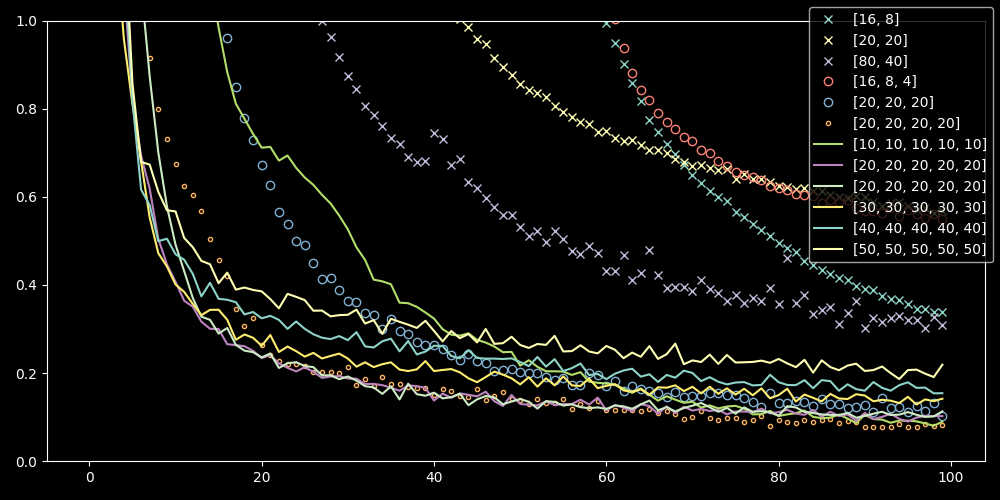

In [72]:
res.sort(key = lambda x: (len(x[-1]), x[-1]))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.set_ylim(bottom=0, top=1)
for i, r in enumerate(res):
    if len(r[-1]) < 3:
        continue
    if len(r[-1]) == 2:
        fmt = 'x'
    elif len(r[-1]) == 3:
        fmt = 'o'
    elif len(r[-1] ) == 4:
        fmt = '.'
    else:
        fmt = '-'
    ax.plot(r[2], fmt, label=str(r[4]), mfc="none")
fig.legend()
    
fig.tight_layout()

In [48]:
for r in res:
    print(r[-1], np.sum(r[-2]))

[80, 40] 248.8988814353943
[16, 8] 245.26063346862793
[20, 20, 20, 20, 20] 307.9186577796936
[16, 8, 4] 270.1607668399811
[20, 20, 20, 20, 20] 304.9801301956177
[20, 20, 20, 20] 281.24507904052734
[20, 20, 20] 265.73049426078796
[20, 20] 238.329984664917


In [ ]:
fig, ax = plt.subplots()
ax.plot(h.history["loss"])
ax.set_ylim(bottom=0)

79/79 [==============================] - 0s 551us/step


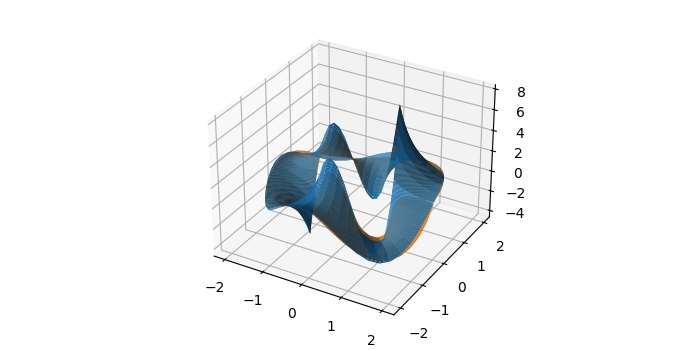

In [273]:
r = np.linspace(1., 2., 50)
f = np.linspace(0, 2*np.pi, 50)
R, F = np.meshgrid(r, f)
Z_P = net.predict(np.stack([R.flatten(),F.flatten()], axis=-1)).reshape(R.shape)
Z_S = solution(R.flatten(), F.flatten()).numpy().reshape(R.shape)
X, Y = R*np.cos(F), R*np.sin(F)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z_S)
ax.plot_surface(X, Y, Z_P)

In [ ]:
n_test = 200
f = np.linspace(0, 2*np.pi, n_test)
analit_in = inner_cond(f)
analit_out = outer_cond(f)
pred_in = net.predict(np.stack([np.full((n_test,), 1.), f], axis=-1))
pred_out = net.predict(np.stack([np.full((n_test,), 2.), f], axis=-1))

fig = plt.figure(figsize=(15.,5.))
ax1 = fig.add_subplot(121)
ax1.plot(f, analit_in, 'o', mfc="none", label='analit')
ax1.plot(f, pred_in, label='predict')
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(f, analit_out, 'o', mfc="none", label='analit')
ax2.plot(f, pred_out, label='predict')
ax2.legend()

# Retrieve Parameter

## Simple Test

In [ ]:
inputs = tf.keras.layers.Input(1)
v = tf.keras.layers.Dense(1, use_bias=False)
out = v(inputs)
m = tf.keras.models.Model(inputs=inputs, outputs=out)

m.compile('adam', 'mse')

In [15]:

x = np.linspace(0, 10, 20)
y = x*3
m.fit(x=x, y=y, epochs=1, verbose=1)

1/1 [==============================] - 0s 3ms/step - loss: 9.3568e-11


In [19]:
v.get_weights()[0][0,0]

2.9999986

## Difur Test

In [32]:
def solution(x):
    return tf.exp(2*x) + tf.exp(x)

In [ ]:
x = tf.constant([[1.],[2.],[3.]])

with tf.GradientTape(persistent=True) as gg:
    gg.watch(x)
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        u = solution(x)
    u_x = g.batch_jacobian(u, x)[..., 0, :]
u_xx = gg.batch_jacobian(u_x, x)[..., 0, :]

print(u)
print(u_x)
print(u_xx)
print(u_xx - 3*u_x + 2*u)

In [51]:
inputs = tf.keras.layers.Input(1)
x = inputs
x = tf.keras.layers.Dense(20, activation='tanh', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(20, activation='tanh', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(20, activation='tanh', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(20, activation='tanh', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(20, activation='tanh', kernel_initializer='he_normal')(x)
out = tf.keras.layers.Dense(1)(x)
net = tf.keras.Model(inputs=inputs, outputs=out)

net.compile('adam', 'mse')

In [ ]:
x = np.linspace(0, 1, 10000)
y = solution(x)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
net.fit(x=x, y=y, epochs=100, callbacks=[es])

In [53]:
for l in net.layers:
    l.trainable = False

In [54]:
class GL(tf.keras.layers.Layer):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def call(self, x):
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                u = self.net(x)
            u_x = g.batch_jacobian(u, x)[..., 0, :]
        u_xx = gg.batch_jacobian(u_x, x)[..., 0, :]
        return u, u_x, u_xx

inputs = tf.keras.layers.Input(1)
u, u_x, u_xx = GL(solution)(inputs)
a = tf.keras.layers.Dense(1, use_bias=False)
b = tf.keras.layers.Dense(1, use_bias=False)
r = u_xx + a(u_x) + b(u)
# r = u_xx - 3*u_x + 2*u
pinn = tf.keras.models.Model(inputs=inputs, outputs=r)
pinn.compile('adam', 'mse')

In [ ]:
x = np.linspace(0, 1, 10000)
u = solution(x)

pinn.fit(x=x, y=np.zeros_like(u), verbose=1, epochs=1000, callbacks=[es])

In [59]:
print(f"{a.weights[0].numpy()[0,0]:.2f} {b.weights[0].numpy()[0,0]:.2f}")

-3.00 2.00


In [ ]:
fig, ax = plt.subplots()
ax.plot(x, u, label='analit')
u_p = net.predict(x)
ax.plot(x, u_p, label='pred')
ax.set_ylim(bottom=0,top=11)
fig.legend()

## Retrieve EK Parameters

In [ ]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "v": tf.keras.layers.Dense(dim, kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)



In [ ]:
net = build_net([20,20,20,20], 'tanh', 3)